### Assignment 5: K Means and K Medoids Clustering

### Objective:
To build Unsupervised models like K-Means, K-Medoids(PAM) clustering to discover hidden and interesting patterns inside the data. Comparing the results of all, Visualizing and interpreting the formed clusters.

### Fatal Police Shooting Data

**About dataset**\
The dataset consists of following columns
1. **id**                         : unqiue identifier of each victim
2. **name**                       : name of a victim
3. **date**                       : date on fatal shooting
4. **manner_of_death**            : manner of death classification
    * Shot
    * Shot and Tasered
5. **armed**                      : indicates that the victim was armed with some sort of implement that a police officer believed could inflict harm
    * undetermined: it is not known whether or not the victim had a weapon
    * unknown: the victim was armed, but it is not known what the object was
    * unarmed: the victim was not armed
6. **age**                        : age of victim
7. **gender**                     : the gender of the victim. The Post identifies victims by the gender they identify with if reports indicate that it differs from their biological sex.
    * M: Male
    * F: Female
    * None: Unknown
8. **race**                       : race of victim
    * W: White, non-Hispanic
    * B: Black, non-Hispanic
    * A: Asian
    * N: Native American
    * H: Hispanic
    * O: Other
    * None: unknown
9. **city**                       : the municipality where the fatal shooting took place. Note that in some cases this field may contain a county name if a more specific municipality is unavailable or unknown.
10. **state**                     : two-letter postal code abbreviation
11. **signs_of_mental_illness**   : News reports have indicated the victim had a history of mental health issues, expressed suicidal intentions or was experiencing mental distress at the time of the shooting.
12. **threat_level**              : These would include incidents where officers or others were shot at, threatened with a gun, attacked with other weapons or physical force, etc. The attack category is meant to flag the highest level of threat. The other and undetermined categories represent all remaining cases. Other includes many incidents where officers or others faced significant threats.
13. **flee**                      : News reports have indicated the victim was moving away from officers
    * Foot
    * Car
    * Not fleeing
14. **body_camera**               : News reports have indicated an officer was wearing a body camera and it may have recorded some portion of the incident.

### Import all neccessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import copy

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

police = pd.read_csv("/content/drive/MyDrive/AIML/fatal-police-shootings-data.csv")
police.head()

Mounted at /content/drive


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [3]:
police.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4478 entries, 0 to 4477
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4478 non-null   int64  
 1   name                     4478 non-null   object 
 2   date                     4478 non-null   object 
 3   manner_of_death          4478 non-null   object 
 4   armed                    4230 non-null   object 
 5   age                      4309 non-null   float64
 6   gender                   4473 non-null   object 
 7   race                     4105 non-null   object 
 8   city                     4478 non-null   object 
 9   state                    4478 non-null   object 
 10  signs_of_mental_illness  4478 non-null   bool   
 11  threat_level             4478 non-null   object 
 12  flee                     4299 non-null   object 
 13  body_camera              4478 non-null   bool   
dtypes: bool(2), float64(1), 

### Let's pre-process the data

In [4]:
# Remove all the rows that contain missing value
police = police.dropna()

In [5]:
police.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

In [6]:
# Drop redundant or not so useful columns for model building
police = police.drop(['id','date','name','city','state'],axis=1)


# We take a copy of our source data.
df = copy.deepcopy(police)
df.head()




,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera
0,shot,gun,53.0,M,A,True,attack,Not fleeing,False
1,shot,gun,47.0,M,W,False,attack,Not fleeing,False
2,shot and Tasered,unarmed,23.0,M,H,False,other,Not fleeing,False
3,shot,toy weapon,32.0,M,W,True,attack,Not fleeing,False
4,shot,nail gun,39.0,M,H,False,attack,Not fleeing,False


In [7]:
# Convert categorical variables to numeric
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature]).codes # Replace strings with an integer

In [8]:
# Convert boolean features to numeric
df = pd.get_dummies(df, columns=['signs_of_mental_illness','body_camera'])

In [9]:
df.head()

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True
0,0,30,53.0,1,0,0,2,0,1,1,0
1,0,30,47.0,1,5,0,2,1,0,1,0
2,1,75,23.0,1,2,1,2,1,0,1,0
3,0,74,32.0,1,5,0,2,0,1,1,0
4,0,53,39.0,1,2,0,2,1,0,1,0


### Let's perform K-Means Clustering on the data

### Question 1: 2 Marks
**Perform K-Means clustering on 1 to 10 clusters using the pre processed data and find each cluster's inertia rate. Also, find the optimal number of clusters.**

1805884.0704340702
741383.7066057211
397045.3208861606
325483.7542189383
260740.63988867734
218159.41444293145
184540.3929543125
152837.79376032218
132908.92547932157
115042.22258589542


Text(0, 0.5, 'Inertia')

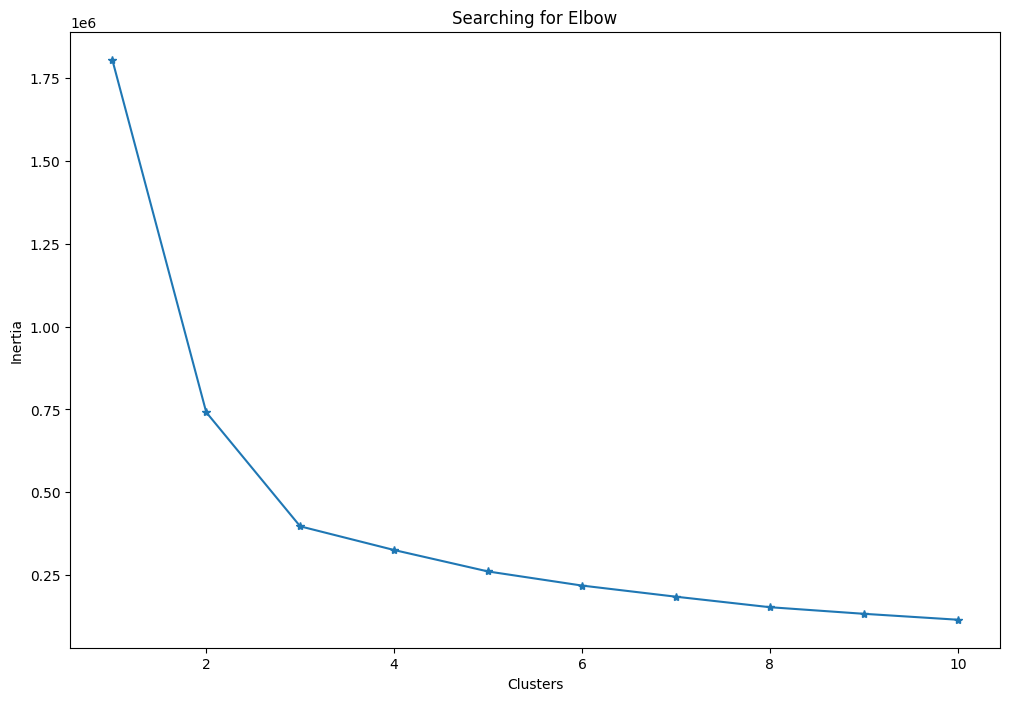

In [10]:
from sklearn.cluster import KMeans      # import corresponding library to perform  kmeans

clusters = []

for i in range(1, 11):       # write a for loop to loop through 1 to 10 clusters.
    km = KMeans(n_clusters=i,random_state = 1).fit(df)   #Fit the pre-processed data to the KMeans clusters from sklearn.cluster library.Save it in the new variable km
    clusters.append(km.inertia_)                     # Append created empty list 'clusters' to capture inertia of all clusters
    print(km.inertia_)


## Plotting Elbow plot to know the optimal number of clusters.
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,11),clusters, marker = '*')
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# TODO: Code to fill:

# 1. '<<__A__>>' --> import corresponding library to perform  kmeans
# 2. '<<__B__>>' --> write a for loop to loop through 1 to 10 clusters.
# 3. '<<__C__>>','<<__D__>> --> write appropriate command to fit the pre-processed data to the KMeans clusters from sklearn.cluster library.Save it in the new variable km
# 4. '<<__E__>>' --> Append created empty list 'clusters' to capture inertia of all clusters

In [11]:
print("Optimal number of cluster is __3___.") # Find out the optimal number of cluster by seeing the Elbow plot and inertia.

Optimal number of cluster is __3___.


### Question 2: 2 Marks
**Perform KMeans Clustering on 3 clusters and assign the cluster labels to a new attribute 'clusters'.**

In [12]:
kmeans = KMeans(n_clusters=3,random_state = 1) # Build K Means of 3 Clusters
kmeans.fit(df)
df_cluster = df.copy()
df_cluster['clusters'] = kmeans.labels_           # Assign Cluster labels on new attribute 'clusters'
df_cluster.head()

# TODO: Code to fill:

# 1. '<<__A__>>','<<__B__>>' --> use appropriate function and paramter to build 3 clusters
# 2.  '<<__C__>>'-->  Use appropriate command to assign Cluster labels on new attribute 'clusters'

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True,clusters
0,0,30,53.0,1,0,0,2,0,1,1,0,2
1,0,30,47.0,1,5,0,2,1,0,1,0,2
2,1,75,23.0,1,2,1,2,1,0,1,0,1
3,0,74,32.0,1,5,0,2,0,1,1,0,1
4,0,53,39.0,1,2,0,2,1,0,1,0,1


### Cluster Profiling

In [13]:
cluster_profiles = df_cluster.groupby('clusters').mean()
cluster_profiles

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True
clusters,,,,,,,,,,,
0,0.046487,31.925515,29.268357,0.963022,2.984680,0.328579,1.589540,0.765452,0.234548,0.880613,0.119387
1,0.074896,74.611650,33.324549,0.938974,3.062413,0.675451,1.443828,0.771151,0.228849,0.857143,0.142857
2,0.049571,31.956149,51.851287,0.950429,3.914204,0.298379,1.777884,0.706387,0.293613,0.907531,0.092469


In [14]:
cluster_profiles = df_cluster.groupby("clusters").mean()
cluster_profiles['Freq']= df_cluster.clusters.value_counts().sort_index()
cluster_profiles.T

clusters,0,1,2
manner_of_death,0.046487,0.074896,0.049571
armed,31.925515,74.611650,31.956149
age,29.268357,33.324549,51.851287
gender,0.963022,0.938974,0.950429
race,2.984680,3.062413,3.914204
threat_level,0.328579,0.675451,0.298379
flee,1.589540,1.443828,1.777884
signs_of_mental_illness_False,0.765452,0.771151,0.706387
signs_of_mental_illness_True,0.234548,0.228849,0.293613
body_camera_False,0.880613,0.857143,0.907531


In [15]:
# let's display cluster profiles
cluster_profiles.style.highlight_max(color="lightgreen", axis=0)

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True,Freq
clusters,,,,,,,,,,,,
0,0.046487,31.925515,29.268357,0.963022,2.984680,0.328579,1.589540,0.765452,0.234548,0.880613,0.119387,1893
1,0.074896,74.611650,33.324549,0.938974,3.062413,0.675451,1.443828,0.771151,0.228849,0.857143,0.142857,721
2,0.049571,31.956149,51.851287,0.950429,3.914204,0.298379,1.777884,0.706387,0.293613,0.907531,0.092469,1049


### Question 3: 2 Marks
**Share you insights from the cluster profiles, 1 observation each.**

### Intepretations:
* Cluster 0  =
* Cluster 1 =
* Cluster 2 =

## K-Medoids Clustering or PAM

- Medoids are representative objects of a data set or a cluster within a data set whose sum of dissimilarities to all the objects in the cluster is minimal. K-Medoids (also called Partitioning Around Medoid)

In [16]:
# To install K Medoids we need sklear-extra, hence install sklear-extra library
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.6 MB/s eta 0:00:00


### Question 4: 2 Marks
**Perform K Medoids or PAM on 1 to 10 clusters using the pre processed data and find each cluster's inertia rate.**

In [17]:
from sklearn_extra.cluster import KMedoids
clusters = []

for i in range(1, 11):
    km = KMedoids(n_clusters=i,random_state = 1).fit(df)
    clusters.append(km.inertia_)
    print(km.inertia_)


# TODO: Code to fill:

# 1. '<<__A__>>' --> import corresponding library to perform K medoids
# 2. '<<__B__>>' --> write a for loop to loop through 1 to 10 clusters.
# 3. '<<__C__>>','<<__D__>> --> write appropriate command to fit the pre-processed data to the kmedoids clusters from sklearn.cluster library.Save it in the new variable km
# 4. '<<__E__>>' --> Append created empty list 'clusters' to capture inertia of all clusters

68980.03620208926
56359.58814678746
32664.536696287338
28776.023806173373
26098.652894748942
25544.274661814285
23587.68001922701
23244.293832559782
21496.67015595424
20167.1582591867


### Question 5: 2 Marks
**Check the Silhouette scores for clusters ranging from 2 to 10 and also visualize them. Find out the optimal number of clusters.**

For n_clusters = 2, the silhouette score is 0.30128748475434614)
For n_clusters = 3, the silhouette score is 0.5215778827107759)
For n_clusters = 4, the silhouette score is 0.4099825101260743)
For n_clusters = 5, the silhouette score is 0.43348558242811247)
For n_clusters = 6, the silhouette score is 0.38185773511329385)
For n_clusters = 7, the silhouette score is 0.427858941948385)
For n_clusters = 8, the silhouette score is 0.4127408630790201)
For n_clusters = 9, the silhouette score is 0.4130675437931936)
For n_clusters = 10, the silhouette score is 0.40325410196089356)


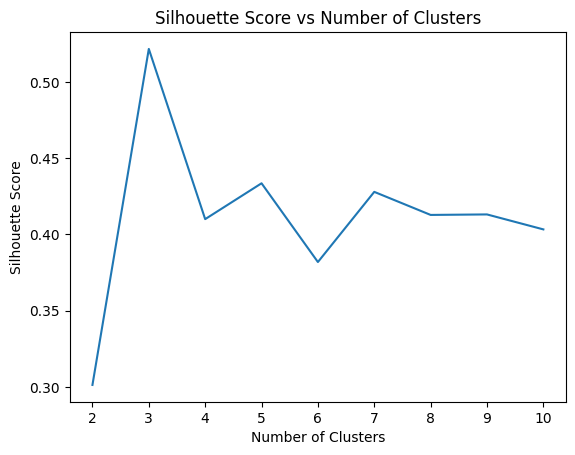

In [18]:
sil_score = []
cluster_list = list(range(2, 11))
for n_clusters in cluster_list:
    clusterer = KMedoids(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df)
    score = silhouette_score(df, preds)
    sil_score.append(score)        # Appending silhourtte scores of 2 to 10 clusters into earlier created empty list sil_score.
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# TODO: Code to fill:

# 1. '<<__A__>>'                         --> Create a list of clusters ranging from 2 to 10.
# 2. '<<__B__>>'                         --> Apply KMedoids algorithm on the created n_clusters
# 3. '<<__C__>>'.'<<__D__>>'             --> Fit and predict above built KMedoids clusters algorithm on pre processed data
# 4. '<<__E__>>'                         --> Find the silhoutte scores from sklearn.metrics library of those n_clusters and store it into a new attribute called 'score'
# 5. '<<__F__>>', '<<__G__>>'            --> Plot all clusters and their corresponding silhouette scores.



In [19]:
print("Optimal number of cluster is _____3_____.") # Find out the optimal number of cluster by seeing the Silhouette scores.

Optimal number of cluster is _____3_____.


In [20]:
kmedoids = KMedoids(n_clusters = 3,random_state = 1)
kmedoids.fit(df)
df_cluster_Med = df.copy()
df_cluster_Med['clusters_Med'] = kmedoids.labels_
df_cluster_Med.head()

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True,clusters_Med
0,0,30,53.0,1,0,0,2,0,1,1,0,2
1,0,30,47.0,1,5,0,2,1,0,1,0,2
2,1,75,23.0,1,2,1,2,1,0,1,0,1
3,0,74,32.0,1,5,0,2,0,1,1,0,1
4,0,53,39.0,1,2,0,2,1,0,1,0,1


### K Medoids Cluster Profiling

**Group the cluster labels by their mean and find the Frequecy of each grouped clusters**

In [21]:
cluster_profiles = df_cluster_Med.groupby("clusters_Med").mean()
cluster_profiles['Freq']= df_cluster_Med.clusters_Med.value_counts().sort_index()
cluster_profiles.T

clusters_Med,0,1,2
manner_of_death,0.047388,0.074896,0.047926
armed,31.957997,74.611650,31.899539
age,29.060312,33.324549,51.458065
gender,0.963382,0.938974,0.950230
race,2.945611,3.062413,3.950230
threat_level,0.328487,0.675451,0.299539
flee,1.590738,1.443828,1.769585
signs_of_mental_illness_False,0.766290,0.771151,0.706912
signs_of_mental_illness_True,0.233710,0.228849,0.293088
body_camera_False,0.878837,0.857143,0.909677


In [22]:
# let's display cluster profiles
cluster_profiles.style.highlight_max(color="lightgreen", axis=0)

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True,Freq
clusters_Med,,,,,,,,,,,,
0,0.047388,31.957997,29.060312,0.963382,2.945611,0.328487,1.590738,0.766290,0.233710,0.878837,0.121163,1857
1,0.074896,74.611650,33.324549,0.938974,3.062413,0.675451,1.443828,0.771151,0.228849,0.857143,0.142857,721
2,0.047926,31.899539,51.458065,0.950230,3.950230,0.299539,1.769585,0.706912,0.293088,0.909677,0.090323,1085


### Interpretation
* Cluster 0  = Highest number of victims belong this group. These people are also young compared to other groups.
* Cluster 1 = Least number of victims belong to this group. These people are mentally stable.
* Cluster 2 = Most of the victims who are older comparitively belong to this group. These people are having highest sign of mental illness.


### Visualization of clusters

- Since most of our variables are categorical in nature let's plot countplot to visualize the formed clusters.


#### K Means Clusters

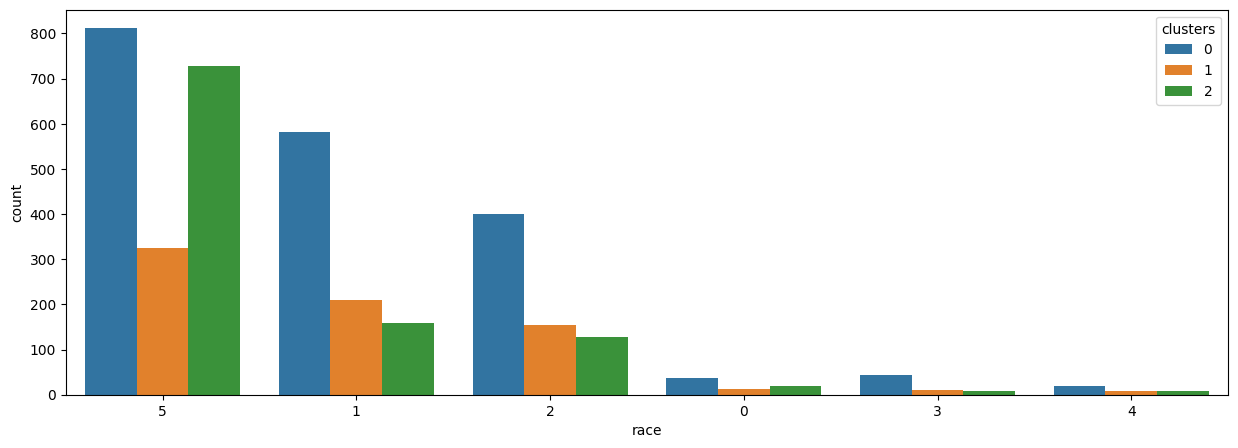

In [23]:
# Plot race clusters
plt.subplots(figsize = (15,5))
sns.countplot(x=df_cluster['race'],order=df_cluster['race'].value_counts().index,hue=df_cluster['clusters'])
plt.show()

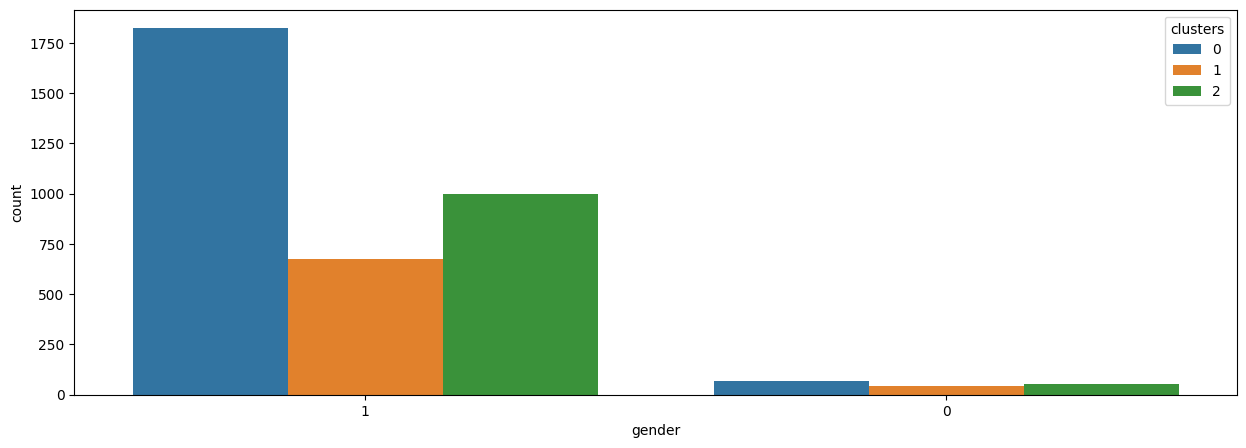

In [24]:
# Plot gender clusters
plt.subplots(figsize = (15,5))
sns.countplot(x=df_cluster['gender'],order=df_cluster['gender'].value_counts().index,hue=df_cluster['clusters'])
plt.show()

#### K Medoids Clusters

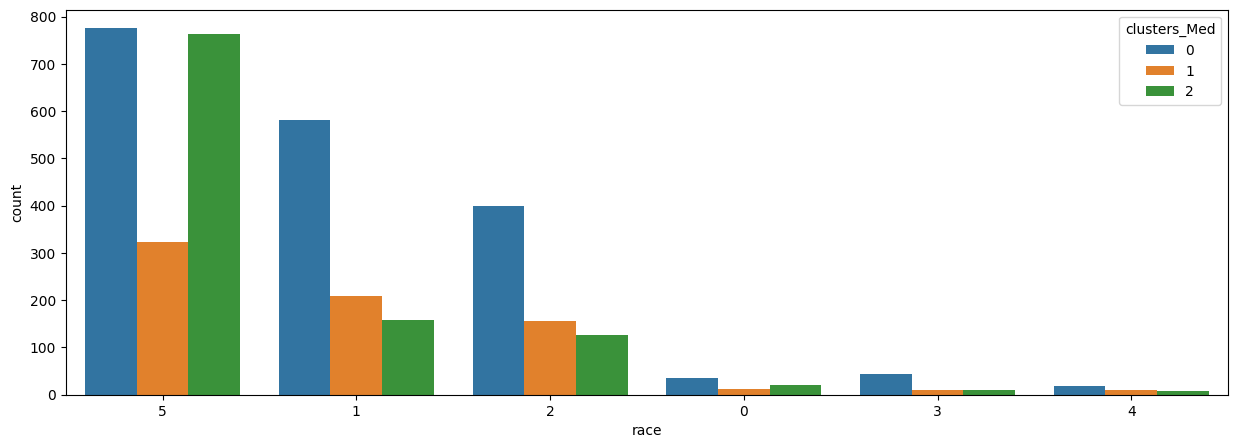

In [25]:
# Plot race clusters
plt.subplots(figsize = (15,5))
sns.countplot(x=df_cluster_Med['race'],order=df_cluster_Med['race'].value_counts().index,hue=df_cluster_Med['clusters_Med'])
plt.show()

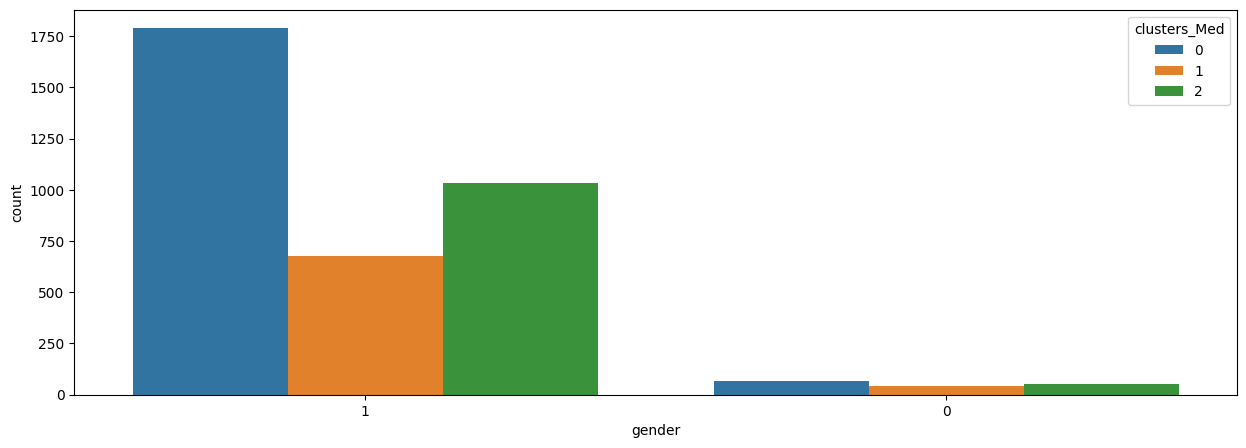

In [26]:
# Plot gender clusters
plt.subplots(figsize = (15,5))
sns.countplot(x=df_cluster_Med['gender'],order=df_cluster_Med['gender'].value_counts().index,hue=df_cluster_Med['clusters_Med'])
plt.show()

#### Conclusion:
* From Cluster profiling and Visualization, we can observe that K-means and K-medoids(PAM) both are giving almost the same results.
* Optimal number of clusters seems to be 3.
* Since most of our variables are categorical in nature we can rely on K Medoids.


In [27]:
!pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!jupyter nbconvert --to html /content/UoA_assesment_w5.ipynb